In [33]:
# analyse PHROG representative sequences and determine testing and validation sets

In [1]:
# imports 
import pandas as pd
from Bio import SeqIO
import re
from collections import Counter
import requests
import seaborn as sns

import pickle
from itertools import chain
import matplotlib.pyplot as plt

In [2]:
# read in all the information needing 
oligomer_predictions = pickle.load(open('../files/pdb_oligomeric_states_mmseqs2_2025-04-08.pkl', 'rb')) 

# add deposition date to the dataframe 
date_dict = dict(zip(oligomer_predictions.keys(), [oligomer_predictions.get(i).get('Deposition_Date') for i in list(oligomer_predictions.keys())]))
states = [str(set([j[0] for j in list(i.get('Assemblies').values())]))[2:-2] for i in oligomer_predictions.values()]
state_dict = dict(zip(oligomer_predictions.keys(), states)) 

In [3]:
# read in the experimental methods to see if NMR structures can be filtered out 
experimental_method = pd.read_csv('/home/grig0076/GitHubs/phlegm/pdb_experimental_methods.csv')
experimental_method_dict = dict(zip([e.lower() for e in experimental_method['PDB_ID'].to_list()], experimental_method['Experimental_Method'].to_list()))
Counter(experimental_method['Experimental_Method'])

Counter({'X-RAY DIFFRACTION': 18146,
         'ELECTRON MICROSCOPY': 3596,
         'SOLUTION NMR': 390,
         'ELECTRON CRYSTALLOGRAPHY': 66,
         'SOLID-STATE NMR': 7,
         'Error 404': 3,
         'NEUTRON DIFFRACTION': 11,
         'FIBER DIFFRACTION': 15})

In [4]:
# Get the mmseqs results 
df = pd.read_csv("../files/phrog_represenative_pdb_seqres_minseqid0.3_c0.7.m8", sep="\t", header=None)
df.columns = [
    "query", "target", "pident", "alnlen", "mismatch", "gapopen",
    "qstart", "qend", "tstart", "tend", "evalue", "bitscore"
]

# Load query and target lengths from FASTA files
def load_lengths(fasta_file):
    return {record.id: len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

query_lengths = load_lengths("../files/nonsingleton_representative_sequences.fasta") # PHROG representative sequences
target_lengths = load_lengths("../files/pdb_seqres.cleaned.txt") # Sequences in the protein databank 

# Map lengths to dataframe
df["qlen"] = df["query"].map(query_lengths)
df["tlen"] = df["target"].map(target_lengths)

# Compute coverage
df["query_coverage"] = (df["qend"] - df["qstart"] + 1) / df["qlen"]
df["target_coverage"] = (df["tend"] - df["tstart"] + 1) / df["tlen"]
df['pdb'] = [re.split('_',i)[0] for i in df['target']]

df['Deposition_Date'] = [date_dict.get(i) for i in df['pdb']]
df['oligomeric_state'] = [state_dict.get(i) for i in df['pdb']]

# filter out heteromeric hits 
df = df[~df['oligomeric_state'].str.contains('Hetero')]

In [5]:
print(", ".join(list(set(df[df['query'] == 'phrog_1048']['pdb']))))


8smf, 8kbj, 8kbm, 8wjd, 8sme, 8kbk, 8kbi, 8wje, 8smg, 8kbl, 8wjc


,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bitscore,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state
14080,phrog_47,8dwj_A,0.976,342,8,0,1,342,1,342,6.609000e-231,709,342,342,1.0,1.0,8dwj,2022-08-01T00:00:00+0000,Monomer


## apply filtering of which pass the plddt checking and length filter 

In [50]:
# determine which phrogs have hits to the pdb
# apply filtering of which pass the plddt checking and length filter 
#phrogs_hitpdb = list(set(df['query']))
phrogs_hitpdb = list(set(df[df['query_coverage']> 0.7]['query'])) # impose a query coverage of 0.7 as well 

# Get the phrogs that pass the length and plddt filters 
with open('../files/phrogs_pass_plddt_length_threshold.txt', 'r') as file:
    phrogs_pass_lengthplddt =  [line.strip() for line in file]
    
# get the intersection of these two sets of phrogs 
phrogs_pass_lengthplddt_hitpdb = list(set(phrogs_hitpdb).intersection(set(phrogs_pass_lengthplddt))) 

In [51]:
# show the length of these so that thehy can be easily added to the paper 
len(phrogs_pass_lengthplddt)

22554

In [52]:
len(phrogs_pass_lengthplddt_hitpdb)

597

In [53]:
# determine the deposition date
cutoff_date = pd.Timestamp("2021-09-30", tz="UTC")

before_cutoff = dict()
after_cutoff = dict()

for p in phrogs_pass_lengthplddt_hitpdb:
    # Extract and parse dates
    dates_raw = df[df['query'] == p]['Deposition_Date']
    dates = pd.to_datetime(dates_raw, errors='coerce')

    # Get oldest valid date
    oldest_date = dates.min()

    if pd.isna(oldest_date):
        continue  # skip if no valid dates

    # Assign to appropriate dictionary
    if oldest_date < cutoff_date:
        before_cutoff[p] = oldest_date
    else:
        after_cutoff[p] = oldest_date


# save the set of validation and threshold phrogs to files 

In [54]:
before_cutoff_phrogs_list = list(before_cutoff.keys())
df_before_cutoff = df[df['query'].isin(before_cutoff_phrogs_list)]
before_cutoff_phrogs_list = list(set(df_before_cutoff[df_before_cutoff['query_coverage'] > 0.7]['query'])) # make sure that there is a query coverage of 0.7
                                 
with open('../files/phrogs_pass_plddt_length_threshold_alphafold_trained.txt', 'w') as file:
    for item in before_cutoff_phrogs_list:
        file.write(f"{item}\n")
        
after_cutoff_phrogs_list = list(after_cutoff.keys())
df_after_cutoff = df[df['query'].isin(after_cutoff_phrogs_list)]

after_cutoff_phrogs_list = list(set(df_after_cutoff[df_after_cutoff['query_coverage'] > 0.7]['query']))                    
with open('../files/phrogs_pass_plddt_length_threshold_validation_alphafold_unseen.txt', 'w') as file:
    for item in after_cutoff_phrogs_list:
        file.write(f"{item}\n")

In [55]:
# Number of phrog representatives to use for determining thresholds 
len(before_cutoff_phrogs_list)

558

In [56]:
# Number of phrog representatives to use for testing
len(after_cutoff_phrogs_list)

39

In [57]:
# determine the oligomeric states recorded for entries 
phrogs_known_state = before_cutoff_phrogs_list + after_cutoff_phrogs_list

phrog_oligomeric_state= dict()
monomer_only = list() # sequences that are only deposited as monomers
for p in phrogs_known_state: 
    
    #oligomeric_state_raw = df[df['query'] == p]['oligomeric_state'].to_list()
    oligomeric_state_raw = df[df['query'] == p][['pdb', 'oligomeric_state']].drop_duplicates()['oligomeric_state'].to_list()
    
    phrog_oligomeric_state[p] = dict(Counter(oligomeric_state_raw))
    
    if list(dict(Counter(oligomeric_state_raw)).keys()) == ['Monomer']: 
        monomer_only.append(p)

# save this dictionary to a file 
pickle.dump(phrog_oligomeric_state, open('../files/phrogs_pass_plddt_length_threshold_oligomeric_state.pkl', 'wb'))

## build a sankey plot to visualise this 
go and make this online so that it easier to control which colours are used 

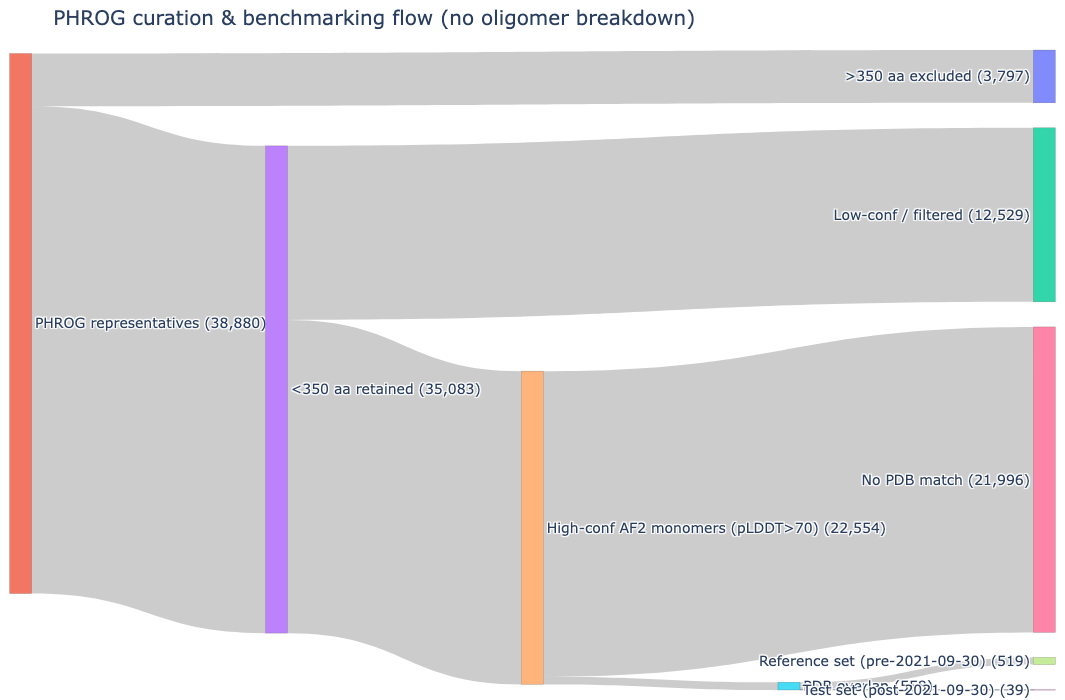

In [24]:
import plotly.graph_objects as go
from collections import defaultdict

# Nodes (no curated/excluded, no oligomeric breakdown)
nodes = [
    ">350 aa excluded",
    "PHROG representatives",
    "Low-conf / filtered",
    "<350 aa retained",
    "High-conf AF2 monomers (pLDDT>70)",
    "PDB overlap",
    "No PDB match",
    "Reference set (pre-2021-09-30)",
    "Test set (post-2021-09-30)",
]

idx = {name: i for i, name in enumerate(nodes)}

# Links without oligomer categories
links = [
    (idx["PHROG representatives"], idx[">350 aa excluded"], 3797, ">350 aa excluded"),
    (idx["PHROG representatives"], idx["<350 aa retained"], 35083, "<350 aa retained"),

    (idx["<350 aa retained"], idx["Low-conf / filtered"], 12529, "pLDDT ≤ 70 / filtered"),
    (idx["<350 aa retained"], idx["High-conf AF2 monomers (pLDDT>70)"], 22554, "pLDDT > 70"),

    (idx["High-conf AF2 monomers (pLDDT>70)"], idx["PDB overlap"], 558, "PDB match"),
    (idx["High-conf AF2 monomers (pLDDT>70)"], idx["No PDB match"], 21996, "No PDB match"),

    (idx["PDB overlap"], idx["Reference set (pre-2021-09-30)"], 519, "Pre-cutoff"),
    (idx["PDB overlap"], idx["Test set (post-2021-09-30)"], 39, "Post-cutoff"),
]

# Compute totals per node (prefer inflow; else outflow)
inflow = defaultdict(int)
outflow = defaultdict(int)
for s, t, v, _ in links:
    outflow[s] += v
    inflow[t] += v

totals = {i: (inflow[i] if inflow[i] > 0 else outflow[i]) for i in range(len(nodes))}

# Labels with counts (special-case the overall total)
labels_with_counts = []
for i, name in enumerate(nodes):
    if name == "PHROG representatives":
        label = f"{name} (38,880)"
    else:
        label = f"{name} ({totals[i]:,})" if totals[i] > 0 else name
    labels_with_counts.append(label)

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    valueformat=",.0f",
    node=dict(
        label=labels_with_counts,
        pad=25,
        thickness=22,
        line=dict(width=0.5, color="rgba(0,0,0,0.3)"),
        hovertemplate="%{label}<extra></extra>"
    ),
    link=dict(
        source=[s for s, t, v, h in links],
        target=[t for s, t, v, h in links],
        value=[v for s, t, v, h in links],
        hovertemplate="%{source.label} → %{target.label}<br>%{value} sequences<extra></extra>"
    )
)])

fig.update_layout(
    title="PHROG curation & benchmarking flow (no oligomer breakdown)",
    font=dict(size=14),
    width=1100,
    height=700,
    margin=dict(l=10, r=10, t=50, b=10)
)

fig.show()


## Look up PDBs corresponding to validation hits for dimers and monomers

In [22]:
set([i[:4] for i in dd['target']])

{'2xvr', '3izg', '3j7v', '3j7w', '3j7x', '7y23', '8i4l'}

In [81]:
val_dimers = ['phrog_45']

for v in val_dimers: 
    dd = df[df['query'] == v]
    print(v)
    print(set([i[:4] for i in dd['target']]))

phrog_45
{'5w5f'}
